In [16]:
# Standard library
import os

# Dependencies
import xarray as xr

# Local imports
os.chdir(os.path.join(os.path.expanduser('~'), "Projects/PaddockTS"))
from DAESIM_preprocess.util import gdata_dir, scratch_dir, visualise_tif_rioxarray, plot_time_series, plot_time_point
from DAESIM_preprocess.topography import show_acc, show_aspect, show_slope, show_ridge_gullies
from DAESIM_preprocess.topography import pysheds_accumulation, catchment_gullies, catchment_ridges, calculate_slope

In [2]:
# Filepaths

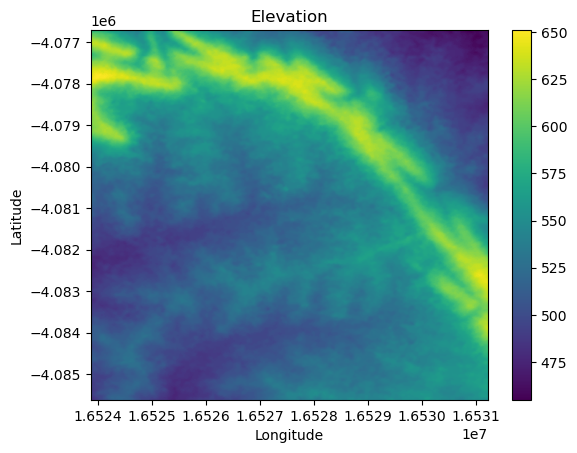

In [3]:
# Visualise elevation
visualise_tif_rioxarray('/g/data/xe2/cb8590/Data/PadSeg/MILG_6km_terrain_cleaned.tif', "Elevation")

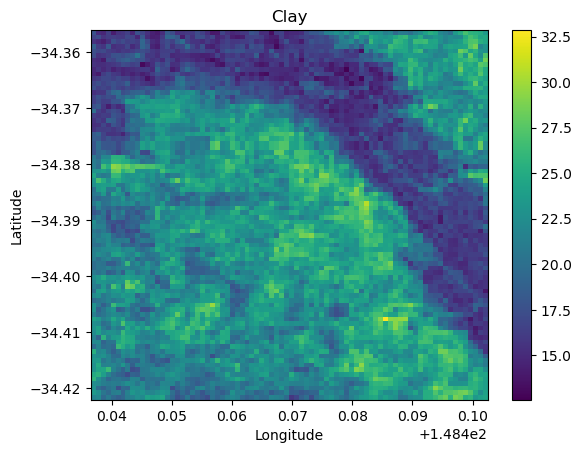

In [4]:
# Visualise soils
visualise_tif_rioxarray("/g/data/xe2/cb8590/Data/PadSeg/MILG_6km_Clay.tif", "Clay")

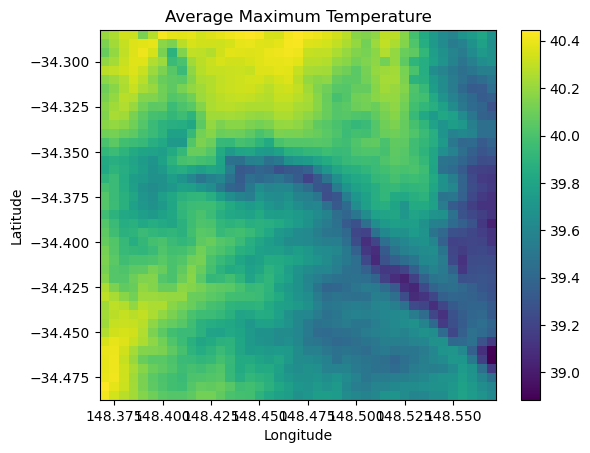

In [5]:
# Visualise climate
visualise_tif_rioxarray("/g/data/xe2/cb8590/Data/PadSeg/MILG_6km_Maximum_Temperature_2020_2021_average.tif", "Average Maximum Temperature")

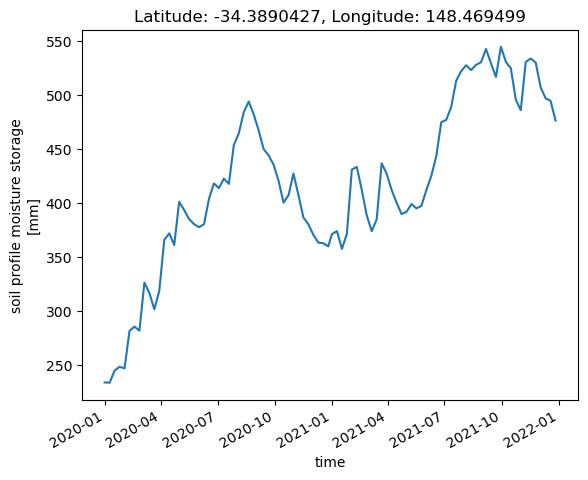

In [12]:
# Visualise weather time series
filename = '/g/data/xe2/cb8590/Data/PadSeg/MILG_1km_ozwald_8day.nc'
ds = xr.open_dataset(filename)
lat, lon = -34.3890427, 148.469499
plot_time_series(ds, "Ssoil", lat, lon)

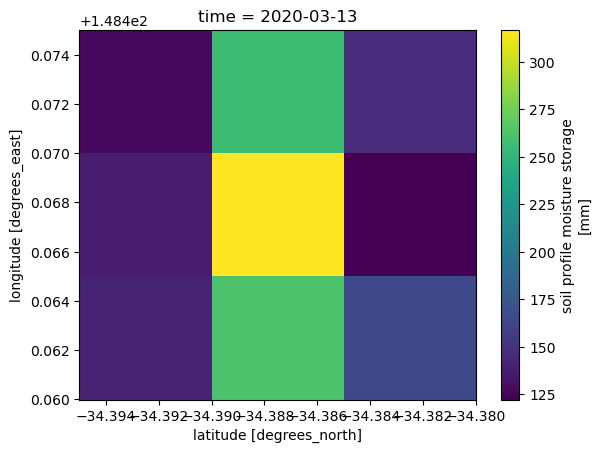

In [13]:
# Visualise weather map
plot_time_point(ds, "Ssoil", "2020-03-10")

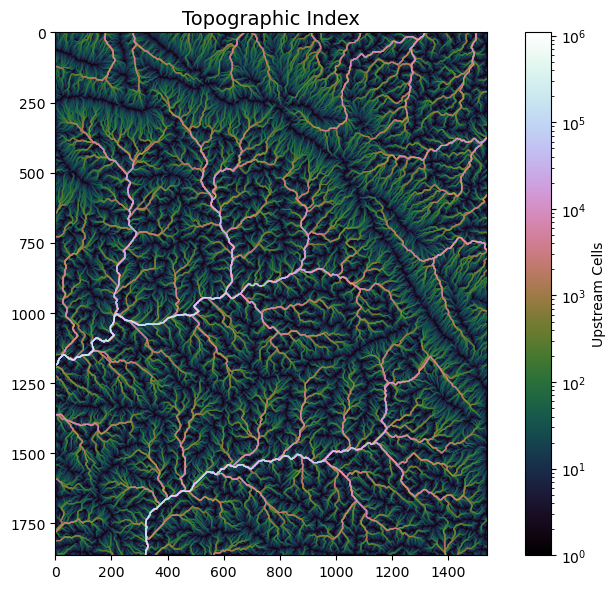

In [17]:
# Visualise topographic index
filepath = "/g/data/xe2/cb8590/Data/PadSeg/MILG_6km_terrain_cleaned.tif"
grid, dem, fdir, acc = pysheds_accumulation(filepath)
show_acc(acc)  # Should export this to a tiff file

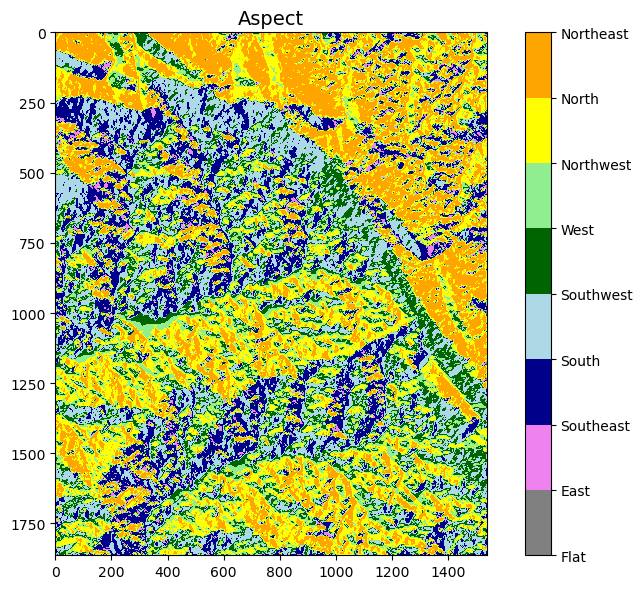

In [18]:
# Visualise aspect
show_aspect(fdir)  # Should export this to a tiff file

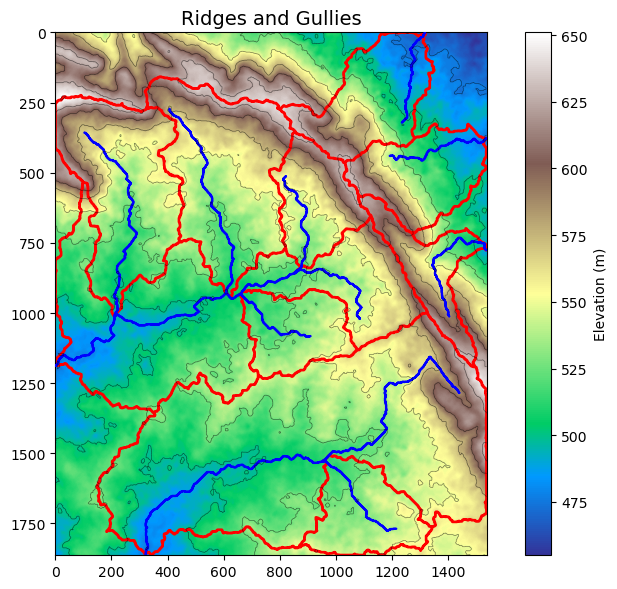

In [19]:
# Visualise ridges and gullies
num_catchments = 10
gullies, full_branches = catchment_gullies(grid, fdir, acc, num_catchments)
ridges = catchment_ridges(grid, fdir, acc, full_branches)
show_ridge_gullies(dem, ridges, gullies)

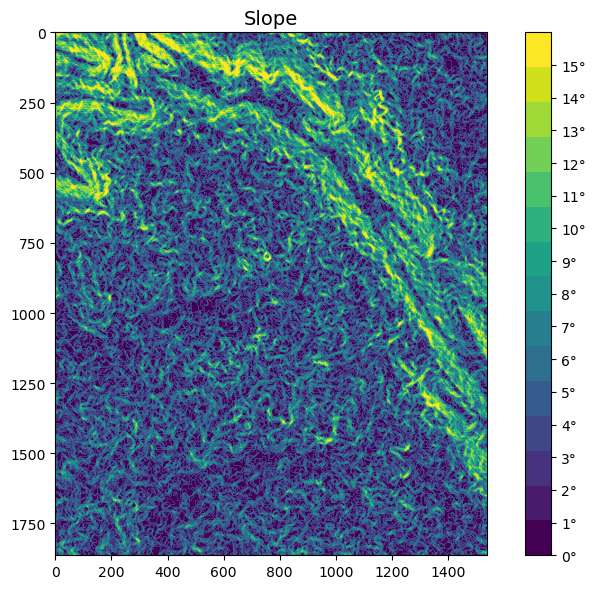

In [20]:
# Visualise slope
slope = calculate_slope(filepath) # Should export this to a tiff file
show_slope(slope)  # Should generalise this function ("show_discrete_variable", and "show_continuous_variable")